# Fire up

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
from ggplot import *
import re
import nltk
from nltk.corpus import stopwords
df = pd.read_csv('data.csv')

# Fast Fact

**Dataset Volume: 1839 Positions**

**Dataset Integrity: Not Perfect. Few web page uses different HTML structure than the others so some important information may be missing in some cases, although the proportion is not large.**

**Feature Extraction: Bag of Word Model and TF-IDF model**

**Classifier Fitted: Decision Tree, Random Forest, Extra Forest,and Voting Classifier ensembling well-performed single model.**

**General Model Performance:**

**Bag of Word 1-gram: Accuracy 0.6957 for voting classifer ensembling decision tree,random forest and extra forest**

**Bag of Word 2/3-gram: Accuracy 0.6495 for voting classifier ensembling random forest and extra forest**

**TF-IDF 1-gram: Accuracy 0.6875 for voting classifer ensembling decision tree,random forest and extra forest**

**General Problem: Relatively poor performances for distinguishing between 1-3 yrs and 3-5 yrs position.**

# Preparation

##  Clean Job Description

During the web scraping, some job descriptions are not collected with perfect integrity. Important information are missing. Therefore, we need to get  rid of those data from the data frame. In order to quickily do this, we just keep the description with more than 200 words.

In [9]:
df['length'] = df['Description'].apply(lambda x: len(str(x).split()))

In [10]:
df = df[df['length']>200]

In [11]:
df.shape

(1839, 3)

In [12]:
def to_words(content):
    letters_only = re.sub("[^a-zA-Z-0-9]", " ", content) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))
df['clean']=df['Description'].apply(lambda x:to_words(str(x)))

## Train, Test Split

Then we split the data set into training and testing set. The test set should be solely used for validating models.

In [13]:
from sklearn.cross_validation import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=42)

# Exploratory Data Analysis

## Length of Clean Description

In [14]:
train['length'] = train['clean'].apply(lambda x: len(str(x).split()))

In [15]:
p = ggplot(aes(x='length'), data=train)
p = p + geom_histogram(binwidth = 25)+facet_wrap('Experience')+xlab('Length of Description')+ylab('Count')+ggtitle('Distribution of lengths of Job Description')+theme_bw()

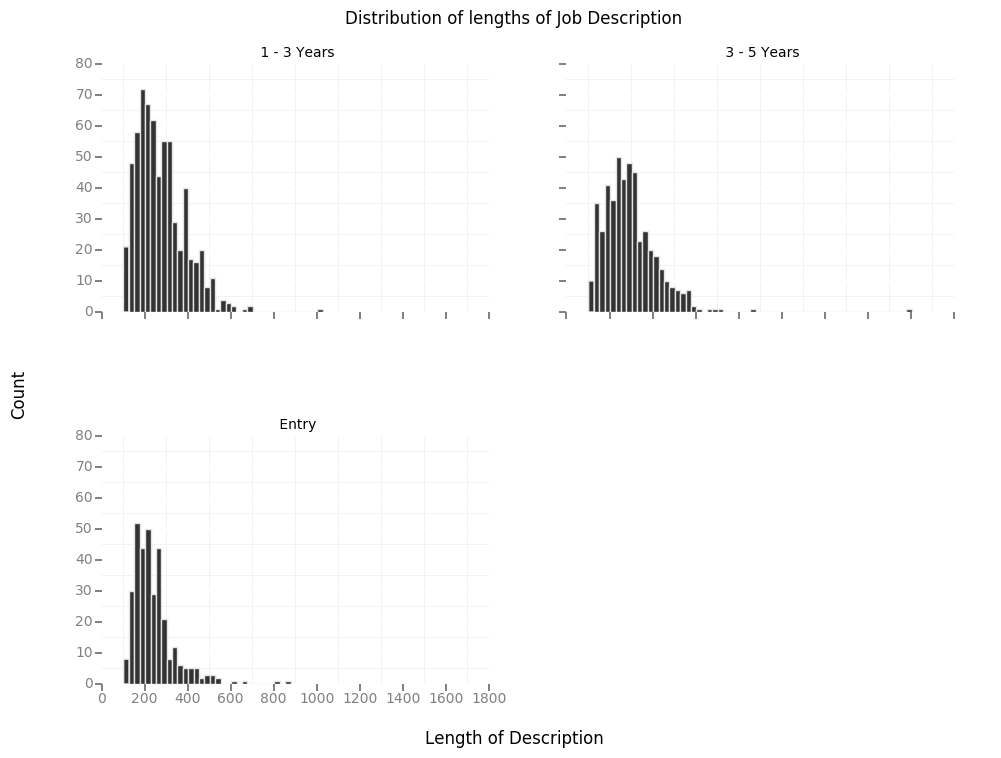

<ggplot: (17406847)>


In [16]:
print(p)

Obviously, positions requiring 1-3 years experience consist of the largest part of the data set. Meanwhile,the lengh of description is also centered around 200-300 words, according to the histogram.

## Term Frequency Exploration

In the second part of EDA, we will focus on finding the frequent term in the positions asking for different years of experience.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
ent = train[train['Experience']==' Entry'] 
ent = ent.reset_index(drop=True)
for i in range(len(ent)):
    if i ==0:
        corp_1 = ent['clean'][i]
    else:
        corp_1 = corp_1 +' ' +ent['clean'][i]

In [18]:
one = train[train['Experience']==' 1 - 3 Years'] 
one = one.reset_index(drop=True)
for i in range(len(one)):
    if i ==0:
        corp_2 = one['clean'][i]
    else:
        corp_2 = corp_2 +' ' +one['clean'][i]

In [19]:
thr = train[train['Experience']==' 3 - 5 Years'] 
thr = thr.reset_index(drop=True)
for i in range(len(thr)):
    if i ==0:
        corp_3 = thr['clean'][i]
    else:
        corp_3 = corp_3 +' ' +thr['clean'][i]

In [20]:
w1 =CountVectorizer().build_tokenizer()(corp_1)
w1_frame = pd.DataFrame([[x,w1.count(x)] for x in set(w1)], columns = ['Word', 'Count'])

In [21]:
w2 =CountVectorizer().build_tokenizer()(corp_2)
w2_frame = pd.DataFrame([[x,w2.count(x)] for x in set(w2)], columns = ['Word', 'Count'])

In [22]:
w3 =CountVectorizer().build_tokenizer()(corp_3)
w3_frame = pd.DataFrame([[x,w3.count(x)] for x in set(w3)], columns = ['Word', 'Count'])

In [23]:
w1_frame = w1_frame.sort('Count',ascending=0)
w2_frame = w2_frame.sort('Count',ascending=0)
w3_frame = w3_frame.sort('Count',ascending=0)
w1_frame = w1_frame[w1_frame['Count']>200]
w2_frame = w2_frame[w2_frame['Count']>300]
w3_frame = w3_frame[w3_frame['Count']>200]

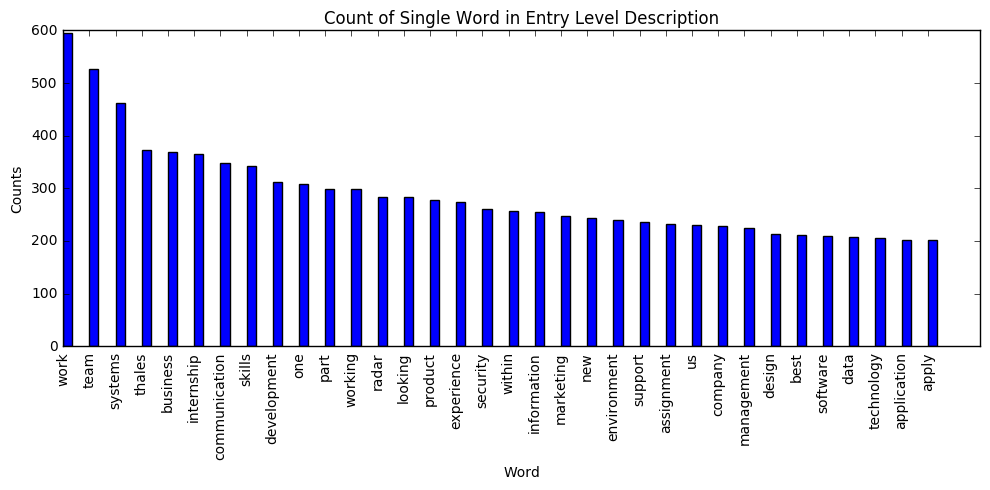

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
index = np.arange(len(w1_frame))
fig, ax = plt.subplots()
rects1 = plt.bar(index, w1_frame['Count'], 0.35)
plt.xlabel('Word')
plt.ylabel('Counts')
plt.title('Count of Single Word in Entry Level Description')
plt.xticks(index ,w1_frame['Word'],rotation=90)
plt.tight_layout()
plt.show()

**Thales....Interesting**

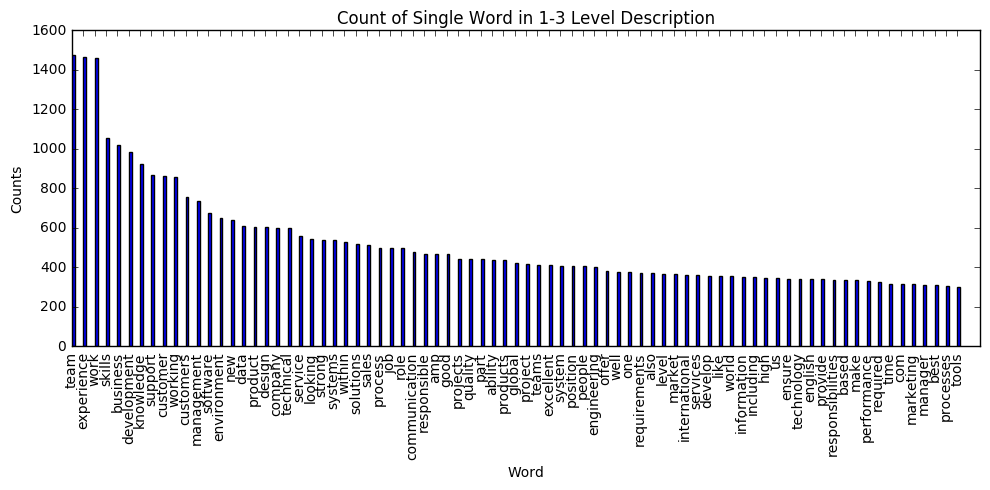

In [25]:
index = np.arange(len(w2_frame))
fig, ax = plt.subplots()
rects1 = plt.bar(index, w2_frame['Count'], 0.25)
plt.xlabel('Word')
plt.ylabel('Counts')
plt.title('Count of Single Word in 1-3 Level Description')
plt.xticks(index ,w2_frame['Word'],rotation=90)
plt.tight_layout()
plt.show()

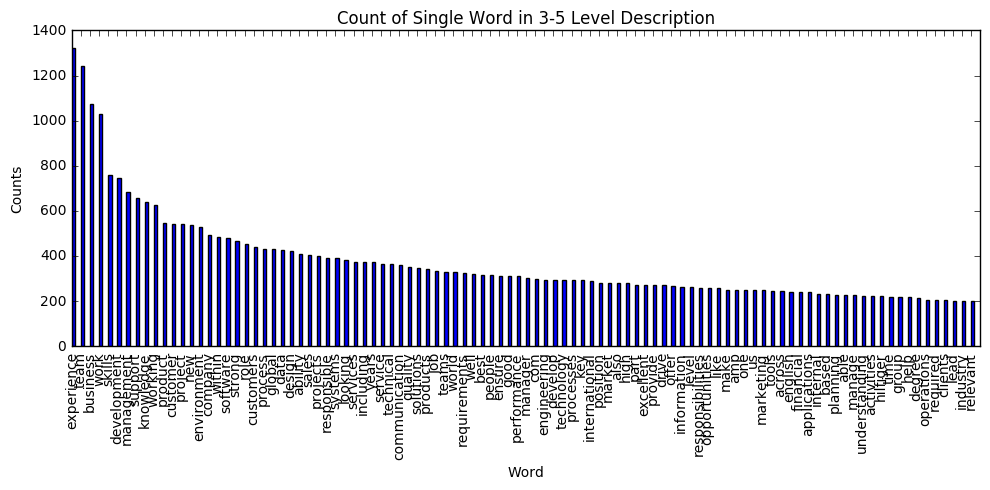

In [26]:
index = np.arange(len(w3_frame))
fig, ax = plt.subplots()
rects1 = plt.bar(index, w3_frame['Count'], 0.35)
plt.xlabel('Word')
plt.ylabel('Counts')
plt.title('Count of Single Word in 3-5 Level Description')
plt.xticks(index ,w3_frame['Word'],rotation=90)
plt.tight_layout()
plt.show()

So it is so obvious that the frequency of 'Experience' becomes higher when the requirement to experience becomes more strict.I have a feeling that **n-gram bag of words model** can be a really cool method for feature extraction!

# Bag of Word Model

## 1-gram BOW 

###  Feature Extraction

In [29]:
train_desc = []
for each in train['clean']:
    train_desc.append(each)

v = CountVectorizer()
feature_1 = v.fit_transform(train_desc)
print(feature_1.shape)

(1471, 17305)


With the 1-gram feature extraction we are able to create 17305 different features for the training set.

###  Model Fitting

Then I try to use the extracted features to fit different classifiers. In this case, since the volume of features is quite large, I will focus on tree model.

In [110]:
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

In [32]:
test_desc = []
for each in test['clean']:
    test_desc.append(each)

After simple manual parameter tunning, following classifiers can be built. Also, I try to ensemble the following models by a voting classifier to see if there is a chance to enhance model performance

In [121]:
clf1=DecisionTreeClassifier(random_state=999, min_samples_leaf=100)
clf2=RandomForestClassifier(n_estimators=200,random_state=999,n_jobs=-1,min_samples_leaf =1 )
clf3=ExtraTreesClassifier(n_estimators=230,random_state=999,n_jobs=-1,min_samples_leaf =1 )
eclf=VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('et', clf3)], voting='soft',weights=[1,2,2])
Classifiers = [clf1,clf2,clf3,eclf]

In [122]:
test_features_1 = v.transform(test_desc)
Model = []
Accuracy = []
for clf in Classifiers:
    fit = clf.fit(feature_1,train['Experience'])
    pred = fit.predict(test_features_1)
    Accu = accuracy_score(pred,test['Experience'])
    Accuracy.append(Accu)
    Model.append(clf.__class__.__name__)
    print('Accuracy of '+clf.__class__.__name__+' is '+str(Accu))

Accuracy of DecisionTreeClassifier is 0.64402173913
Accuracy of RandomForestClassifier is 0.6875
Accuracy of ExtraTreesClassifier is 0.673913043478
Accuracy of VotingClassifier is 0.695652173913


**The voting classifier shows better result over single models.** Further details of classification result are presented below.

In [131]:
pd.crosstab(test['Experience'], pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,1 - 3 Years,3 - 5 Years,Entry
Actual,,,
1 - 3 Years,143,37,3
3 - 5 Years,57,57,0
Entry,13,2,56


We can see that the biggest errors occur between 1-3 years position and 3-5 years position. More intelligent feature selection technique should be implemented.

Meanwhile, one must also care about which word is more predictive in terms of judging working experience. We re-fit the random forest classifier in order to see the importance of features.

In [133]:
rf = RandomForestClassifier(n_estimators=200,random_state=999,n_jobs=-1,min_samples_leaf =1 )
fit = rf.fit(feature_1,train['Experience'])

In [139]:
words = v.get_feature_names()
importance = rf.feature_importances_
impordf = pd.DataFrame({'Word' : words, 
                        'Importance' : importance})
impordf = impordf.sort_values(['Importance', 'Word'], ascending=[0, 1])
impordf.head(20)

,Importance,Word
8368,0.012966,internship
8353,0.009679,intern
14905,0.007468,student
17210,0.005899,years
10139,0.005796,months
13925,0.003954,senior
5956,0.003945,experience
5779,0.003796,europes
1387,0.003788,anticipation
1658,0.003633,assignment


In [140]:
impordf.tail(20)

,Importance,Word
17272,0.0,zero
17273,0.0,zeromq
17274,0.0,zgv2awthljmxndg2lje3njbaawjvlmfwbgl0cmfrlm
17277,0.0,zhivko
17279,0.0,ziekteverzuim
17281,0.0,zigbee
17285,0.0,zinvol
17286,0.0,zoals
17288,0.0,zoekjaarvisum
17290,0.0,zoeterwoude


Many variables are of zero importance for the classification. Some of them are even not English. Maybe a **feature selection step** before model fitting will be helpful. (**Worth Trying**)

## 2-gram, 3-gram BOW

Sometime a phrase may contain more meaning than a single word. In the following part, I will try to extract two and three gram phrase from the training set.

### Feature Extraction

In [141]:
v2 = CountVectorizer(ngram_range=(2,3))
features_2 = v2.fit_transform(train_desc)

In [142]:
print(features_2.shape)

(1471, 443838)


Ok....seems the dimension of data set is too high. I may reduce the dimension of data set by implementing a feature selection step before fitting the data set into the classifiers.

In [146]:
from sklearn.feature_selection import SelectFromModel
cla = ExtraTreesClassifier(random_state=999,n_estimators=200,n_jobs=-1)
cla = cla.fit(features_2, train['Experience'])
select = SelectFromModel(cla, prefit=True)
New_features = select.transform(features_2)
print(New_features.shape)

(1471, 52099)


No idea whether this will be effective, but worth a try

In [147]:
test_features_2 = v2.transform(test_desc)
New_test_2 = select.transform(test_features_2)
print(New_test_2.shape)

(368, 52099)


### Model Fitting

In [165]:
clf1_2=DecisionTreeClassifier(random_state=999, min_samples_leaf=10)
clf2_2=RandomForestClassifier(n_estimators=400,random_state=999,n_jobs=-1,min_samples_leaf =1 )
clf3_2=ExtraTreesClassifier(n_estimators=400,random_state=999,n_jobs=-1,min_samples_leaf =1 )
eclf_2=VotingClassifier(estimators=[('rf', clf2_2), ('et', clf3_2)], voting='hard')
Classifiers_2 = [clf1_2,clf2_2,clf3_2,eclf_2]

In [166]:
Model_2 = []
Accuracy_2 = []
for clf2 in Classifiers_2:
    fit = clf2.fit(New_features,train['Experience'])
    pred = fit.predict(New_test_2)
    Accu = accuracy_score(pred,test['Experience'])
    Accuracy_2.append(Accu)
    Model_2.append(clf2.__class__.__name__)
    print('Accuracy of '+clf2.__class__.__name__+' is '+str(Accu))

Accuracy of DecisionTreeClassifier is 0.535326086957
Accuracy of RandomForestClassifier is 0.64402173913
Accuracy of ExtraTreesClassifier is 0.646739130435
Accuracy of VotingClassifier is 0.649456521739


The bag of word model with two and three gram phrase **does not** improve the performance of classification. 

In [167]:
pd.crosstab(test['Experience'], pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,1 - 3 Years,3 - 5 Years,Entry
Actual,,,
1 - 3 Years,165,15,3
3 - 5 Years,80,34,0
Entry,30,1,40


The new Bag of Word model make the classification of experienced position worse than before. Entry level? still accurate.

How about important phrases?

In [177]:
fit = clf2_2.fit(New_features,train['Experience'])
words = np.asarray(v2.get_feature_names())[select.get_support()]
importance = clf2_2.feature_importances_
impordf = pd.DataFrame({'Word' : words, 
                        'Importance' : importance})
impordf = impordf.sort_values(['Importance', 'Word'], ascending=[0, 1])
impordf.head(20)

,Importance,Word
372,0.004683,35 years
51833,0.004626,years experience
26748,0.003389,looking intern
373,0.002454,35 years experience
25818,0.002452,least years
46013,0.002300,team members
27090,0.001894,mainsprings business examples
9900,0.001844,countries making one
26828,0.001827,looking student
47789,0.001755,track record


In [178]:
impordf.tail(20)

,Importance,Word
52000,0.0,young bright minds
52001,0.0,young company start
52008,0.0,young growing team
52011,0.0,young rapidly growing
52014,0.0,young talent addition
52020,0.0,younger designers
52025,0.0,youre able handle
52026,0.0,youre also
52036,0.0,youre forefront determining
52039,0.0,youre good table


It is obvious! Some phrases are really indicative! I got a feeling that my parameter tuning techniques are not good enough to create an algorithm that match the informative features. **Another potential reason I guess is the feature selection process**

# Tf-idf  Model

Except for Bag of Words model, TF-IDF model is another way to extract features from the text data, This model can emphasize the unique characteristic of text while the words that appear in most text will be given to less weight.

###  Feature Extraction

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
t = TfidfVectorizer()
t_features = t.fit_transform(train_desc)

In [180]:
print(t_features.shape)

(1471, 17305)


## Model Fitting

In [192]:
clf1_3=DecisionTreeClassifier(random_state=999, min_samples_leaf=10)
clf2_3=RandomForestClassifier(n_estimators=300,random_state=999,n_jobs=-1,min_samples_leaf =1 )
clf3_3=ExtraTreesClassifier(n_estimators=300,random_state=999,n_jobs=-1,min_samples_leaf =1 )
eclf_3=VotingClassifier(estimators=[('dt',clf1_3),('rf', clf2_2), ('et', clf3_2)],voting='soft',weights=[1,2,2])
Classifiers_3 = [clf1_3,clf2_3,clf3_3,eclf_3]

In [193]:
test_features_2 = t.transform(test_desc)
Model_3 = []
Accuracy_3 = []
for clf3 in Classifiers_3:
    fit = clf3.fit(t_features,train['Experience'])
    pred = fit.predict(test_features_2)
    Accu = accuracy_score(pred,test['Experience'])
    Accuracy_3.append(Accu)
    Model_3.append(clf3.__class__.__name__)
    print('Accuracy of '+clf3.__class__.__name__+' is '+str(Accu))

Accuracy of DecisionTreeClassifier is 0.652173913043
Accuracy of RandomForestClassifier is 0.673913043478
Accuracy of ExtraTreesClassifier is 0.665760869565
Accuracy of VotingClassifier is 0.6875


Like before, we check the confusion matrix of model.

In [194]:
pd.crosstab(test['Experience'], pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,1 - 3 Years,3 - 5 Years,Entry
Actual,,,
1 - 3 Years,136,43,4
3 - 5 Years,55,59,0
Entry,9,4,58


It is actually, very close to the 1-gram BOW model.

In [195]:
fit = clf2_3.fit(t_features,train['Experience'])
words = t.get_feature_names()
importance = clf2_3.feature_importances_
impordf = pd.DataFrame({'Word' : words, 
                        'Importance' : importance})
impordf = impordf.sort_values(['Importance', 'Word'], ascending=[0, 1])
impordf.head(20)

,Importance,Word
8368,0.011850,internship
8353,0.009297,intern
14905,0.007328,student
10139,0.005117,months
17210,0.004913,years
5956,0.004541,experience
1658,0.004448,assignment
544,0.003892,68
17074,0.003557,workforce
12641,0.003271,radar


In [196]:
impordf.tail(20)

,Importance,Word
17259,0.0,zaandam
17262,0.0,zalando
17263,0.0,zbb
17266,0.0,zealous
17269,0.0,zemax
17271,0.0,zendesk
17273,0.0,zeromq
17274,0.0,zgv2awthljmxndg2lje3njbaawjvlmfwbgl0cmfrlm
17278,0.0,zich
17280,0.0,ziet


Feature importance? Not quite different from the first model.

# What's Next?

a. Find a way larger data set and continue to fit different model.

b. Improve the parameter tuning technique for the simple model.

c. If possible, **find the general patterns in part of job description by using regular expression. This may be tricky but can significantly reduce the dimension of data set.**

d. 'n-gram' model: **try** different n and find the most suitable one!

# Appendix: Web Scraping Code for Data Collection

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas

Position = []
Company = []
Position_Desc = []
Job_Type = []
Background = []
Experience = []
Degree = []
Location = []
Date = []
Language = []
for m in range(1,271): # 270
    urls = []
    url = 'http://hoitalent.com/position/?wpv_aux_current_post_id=6779&wpv_sort_orderby=post_date&wpv_sort_order=desc&wpv_view_count=6782-TCPID6779&wpv_paged='+str(m)
    request = requests.get(url)
    content = request.content
    parser = BeautifulSoup(content,"html.parser")
    All_href = parser.select('.single-position-row div a')
    for i in range(0,len(All_href),3):
        urls.append(All_href[i].get('href'))
        Position.append(All_href[i].getText())
    for j in range(1,len(All_href),3):
        Company.append(All_href[j].getText())
    for each in urls:
        request_2 = requests.get(each)
        content_2 = request_2.content
        parser_2 = BeautifulSoup(content_2,"html.parser")
        if len(parser_2.select('li.list-group-item'))>4:
            slt = parser_2.findAll("div", { "class" : "wpcf-field-wysiwyg wpcf-field-job-description" })
            for ii in slt:
                Position_Desc.append(ii.getText())
            select = parser_2.select('li.list-group-item')
            Type = filter(None,select[0].getText().split('\n'))
            Type = Type[1:]
            Job_Type.append(Type)
            BG=filter(None,select[1].getText().split('\n'))
            BG=BG[1:]
            Background.append(BG)
            LG = filter(None,select[2].getText().split('\n'))
            LG = LG[1:]
            Language.append(LG)
            EP = filter(None,select[3].getText().split('\n'))[1:]
            Experience.append(EP)
            DG = filter(None,select[4].getText().split('\n'))[1:]
            Degree.append(DG)
            LOC = filter(None,select[5].getText().split('\n'))[1:]
            Location.append(LOC)
            DT = filter(None,select[6].getText().split('\n'))[1:]
            Date.append(DT)
        else:
            Position_Desc.append('Not Available')
            Job_Type.append('Not Available')
            Background.append('Not Available')
            Language.append('Not Available')
            Experience.append('Not Available')
            Degree.append('Not Available')
            Location.append('Not Available')
            Date.append('Not Available')
    print('Scraping of Page '+str(m)+' is done!')

df = pandas.DataFrame({'Position':Position,'Company':Company,'Description':Position_Desc,'Job_Type':Job_Type,'Background':Background,'Language':Language,'Degree':Degree,'Date':Date,'Experience':Experience,'Location':Location})
